In [1]:
pip install pykalman


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 3.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [67]:
df=pd.read_csv('drive/MyDrive/lab4/Vietcombank.csv')
df
df1=df.reset_index()['Close']

In [68]:
df

,Date,Open,High,Low,Close,Volume
0,2019-03-01 00:00:00+07:00,40478.95313,41275.25781,40346.23438,41275.25781,1225908
1,2019-03-04 00:00:00+07:00,41275.25781,41806.13281,41275.25781,41673.41406,2030592
2,2019-03-05 00:00:00+07:00,41673.41406,42337.00391,41474.33594,41806.13281,2376092
3,2019-03-06 00:00:00+07:00,41872.48828,42005.20703,41076.18359,41607.05469,2107101
4,2019-03-07 00:00:00+07:00,41607.05469,42337.00391,41540.69531,41872.48828,3091640
...,...,...,...,...,...,...
1301,2024-05-27 00:00:00+07:00,90400.00000,90600.00000,89700.00000,90200.00000,1258620
1302,2024-05-28 00:00:00+07:00,89800.00000,90700.00000,89800.00000,90700.00000,1814349
1303,2024-05-29 00:00:00+07:00,90800.00000,91000.00000,89800.00000,89800.00000,1186438
1304,2024-05-30 00:00:00+07:00,89500.00000,89700.00000,88500.00000,88600.00000,2400732


In [69]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [70]:
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [71]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [72]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest= create_dataset(test_data, time_step)

In [73]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)



(813, 100)
(813,)
(291, 100)
(291,)


In [74]:
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=X_train[0][0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

In [75]:
kf = kf.em(X_train[0])

In [76]:
test_data.shape

(392, 1)

In [77]:
test_observed = test_data
test_predicted, _ = kf.filter(test_observed)


In [78]:
test_predicted.shape

(392, 1)

In [79]:
test_predicted=scaler.inverse_transform(test_predicted)
ytest=ytest.reshape(-1,1)
ytest=scaler.inverse_transform(test_data)

In [80]:
test_rmse = np.sqrt(np.mean((test_predicted - ytest)**2))
test_mae = mean_absolute_error(test_predicted, ytest)
test_mape = np.mean(np.abs(test_predicted - ytest)/np.abs(test_predicted))*100

In [81]:
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 719.2160916877463
Testing MAPE: 0.4268612917629898
Testing MAE: 317.71048628982265


In [82]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape[1]

332

In [83]:
test_data[60:].shape

(332, 1)

In [84]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        #print(x_input)
        yhat, _ = kf.filter(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat[-1].tolist())
        i=i+1
    else:
        x_input = x_input.reshape(n_steps)
        yhat, _ = kf.filter(x_input)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat[-1].tolist())
        i=i+1

Streaming output truncated to the last 5000 lines.
 0.26328687 0.24586278 0.25544602 0.25021881 0.25675284 0.25239681
 0.24804077 0.25021881 0.24760518 0.25021881 0.25370362 0.25544602
 0.25021881 0.25152558 0.25239681 0.24934759 0.25239681 0.25021881
 0.25108999 0.24107115 0.24150674 0.24542718 0.24673396 0.25021881
 0.24629837 0.24368474 0.24150674 0.24324915 0.24150674 0.23279472
 0.21580621 0.22190465 0.23279472 0.24019993 0.23279472 0.24150674
 0.24499155 0.24716959 0.24891199 0.24324915 0.24934759 0.24586278
 0.24629837 0.24237796 0.23715071 0.23279472 0.22930986 0.2297455
 0.22930986 0.23018109 0.23018109 0.22843868 0.23061668 0.2297455
 0.22626069 0.22800309 0.2297455  0.23453712 0.23715071 0.23932875
 0.23061668 0.23627953 0.25021881 0.24716959 0.24586278 0.24150674
 0.24934759 0.24455596]
77 day output [[0.24847636]
 [0.53219877]
 [0.65807957]
 [0.68942812]
 [0.68817627]
 [0.68482824]
 [0.68182639]
 [0.68683611]
 [0.67651233]
 [0.68422037]
 [0.70041572]
 [0.70043506]
 [0.6994

In [85]:
# Chuyển danh sách thành mảng numpy
values_array = np.array(lst_output)

# Nếu bạn thực sự cần reshape (ví dụ: thành mảng 2D 1 hàng)
values_reshaped = values_array.reshape(-1, 1)

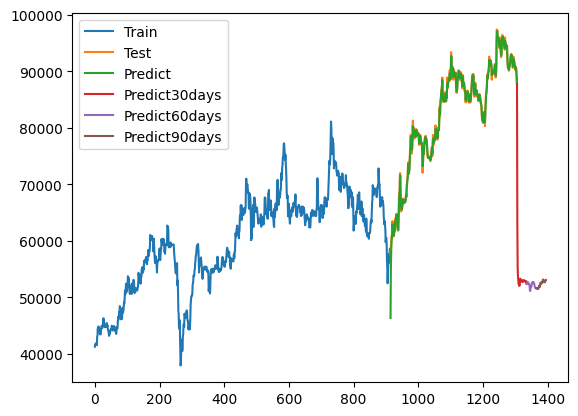

In [86]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_predicted)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[60:90]))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.show()



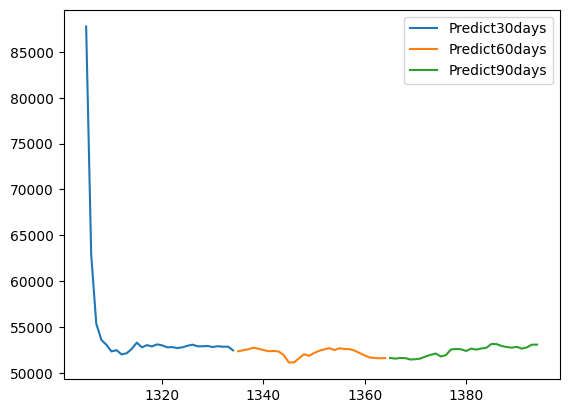

In [87]:


prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[60:90]))

plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.show()